## Markov Chain Monte Carlo

Suppose you wish to draw samples from a posterior distribution $p(\theta|x)$ and that the computation of the normalization factor 

$$p(x) = \int_\theta p(x|\theta) p (\theta) d \theta$$ 

is intractable, due to the high dimensionality of the problem. 

MCMC is a class of algorithms that allow to perform sampling from the **unkown probability distribution** $p(\theta|x)$,  whose density is proportional to the **known unnormalized factor** $p(x|\theta) p (\theta)$.

The basic idea is that of building a Markov chain that has the desired distribution as its equilibrium distribution. This way, one can obtain a sample of the desired distribution by recording states from the chain and the more steps that are included, the more closely the distribution of the sample matches the desired distribution $p(\theta|x)$.

<div> 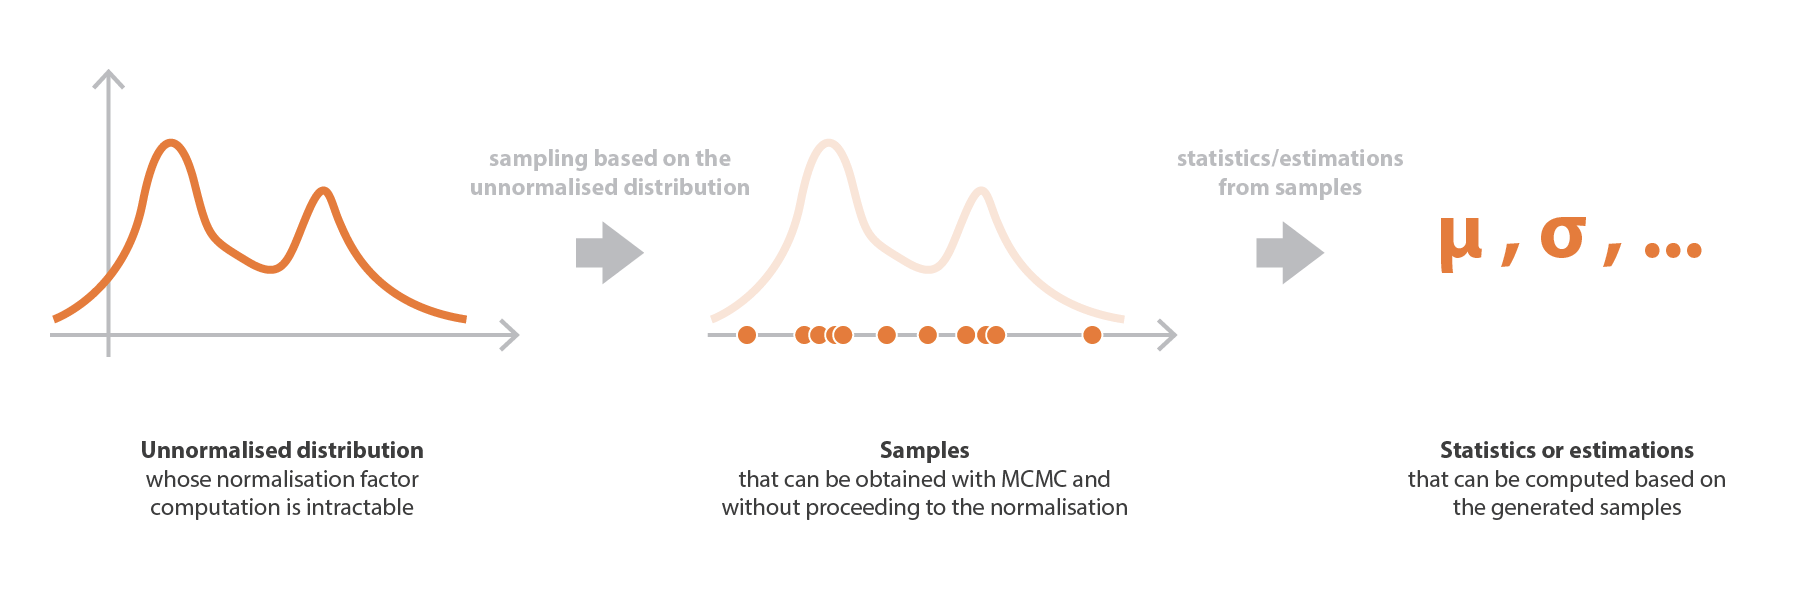</div>

[https://towardsdatascience.com/bayesian-inference-problem-mcmc-and-variational-inference-25a8aa9bce29](https://towardsdatascience.com/bayesian-inference-problem-mcmc-and-variational-inference-25a8aa9bce29)

### Conditioning in Pyro

Probabilistic programming allows us to condition generative models on observed data and to perform inference on it. In Pyro, we can separate the conditioning step from its evaluation via inference: first write a model and then condition it on many different observations.

Let's go back to an example from notebook 2. We are trying to measure the weight of an object, but we don't have access to the true weights, because the scale is unreliable. 
Instead, we can use a **model of the measurement noise** plus an initial **uncertain guess** (based on some properties of the object) to obtain an **uncertain estimate of the true weight**. 

$$weight \, | \, guess \sim \mathcal{N}(guess, 1)$$

$$ measurement \, | \, guess, weight \sim \mathcal{N}(weight, 0.75^2) $$



In [41]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pyro
import pyro.distributions as dist
from pyro.infer.mcmc import MCMC, HMC, NUTS
pyro.set_rng_seed(0)

In [42]:
def scale(guess=8.5):
    
    # models weight in terms of the initial guess
    weight = pyro.sample("weight", dist.Normal(guess, 1.0))

    # models measurement noise
    measurement = pyro.sample("measurement", dist.Normal(weight, 0.75))
    
    return measurement

Suppose that we observe a measurement of the object corresponding to 9.5 kg. We want to sample from the distribution of the weight given both the observation `measurement = 9.5` and an input knowledge `guess = 8.5`. In other words, we wish to infer the distribution 

$$weight \, | \, guess, measurement=9.5 \sim ?$$

Pyro provides a method called `pyro.condition` that takes as inputs a model and a dictionary of observations and returns a new model which is conditioned on the observations.

In [2]:
# condition the model on a single observation
obs = torch.tensor(9.5)
conditioned_scale = pyro.condition(scale, data={"measurement": obs})

`conditioned_scale()` could be equivalently defined by using the `obs` parameter directly inside the model definition:

In [4]:
def conditioned_scale(obs, guess=8.5): 
    weight = pyro.sample("weight", dist.Normal(guess, 1.))
    measurement = pyro.sample("measurement", dist.Normal(weight, 1.), obs=obs)
    return measurement

### Hamiltonian Monte Carlo

Hamiltonian Monte Carlo (HMC) combines an approximate Hamiltonian dynamics simulation and a Metropolis-Hastings acceptance step. It is designed to reduce the problems of *low acceptance rates* and *autocorrelation* bewteen consecutive samples.

Suppose you want to compute an expectation w.r.t. an intractable posterior distribution $\pi(q)$. It reduces to an integral over the whole parameter space, but the most significant contributions to the computation of this integral come from a smaller region between the mode and the tails of the target distribution, which is called the **typical set**.

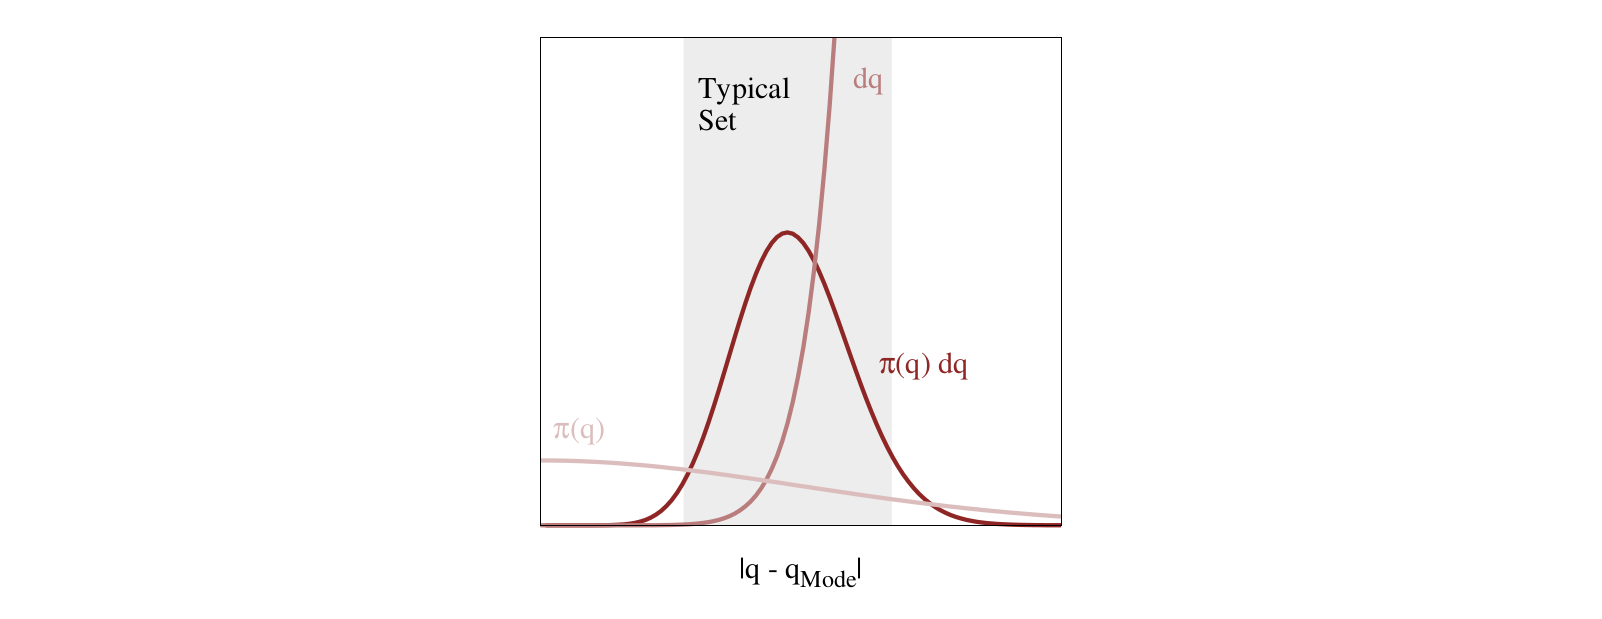
<div align="center" style="color:darkblue">M. Bentacourt, "A Conceptual Introduction to
Hamiltonian Monte Carlo", 2018</div>

HMC introduces an additional *momentum* variable with the aim of favouring the exploration of the typical set, instead of drifting towards the tails or the mode of $\pi$.

### HMC on conditioned scale model

Let's perform inference on the conditioned scale model by using HMC and a few `measurement` observations, with the aim of getting an estimate of the expected weight.

In [29]:
hmc_kernel = HMC(model=conditioned_scale) # transition kernel
mcmc = MCMC(hmc_kernel, num_samples=500, warmup_steps=1000, num_chains=3)

`warmup_steps` refers to the **burn-in** period, which is the number of discarded samples before performing the actual sampling of `num_samples` values from the (hopefully) stationary distribution.

`num_chains` is the number of independent MCMC runs, subject to different initializations. Pyro automatically computes them in parallel.

In [15]:
# measurement observations
obs = torch.tensor([8.2, 9.6, 7.8, 9.1])

# posteriors 
posterior = mcmc.run(obs=obs)

# dictionary of sampled values
print(mcmc.get_samples().keys())




dict_keys(['weight'])


torch.Size([3, 100])


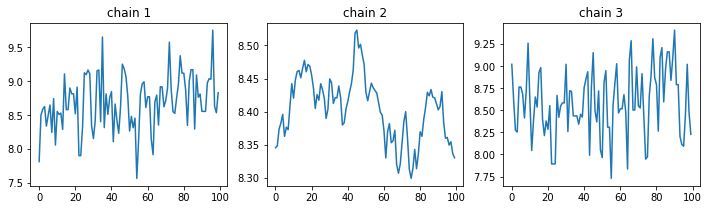

In [16]:
# extracting weight samples and grouping them by chains
mcmc_samples = mcmc.get_samples(group_by_chain=True)
chains = mcmc_samples["weight"]

n_chains, n_samples = chains.shape
print(chains.shape)

fig, ax = plt.subplots(1, n_chains, figsize=(12,3))
for i, chain in enumerate(chains):
    sns.lineplot(x=range(n_samples), y=chain, ax=ax[i])
    ax[i].set_title("chain "+str(i+1))

expected weight = 8.558907508850098


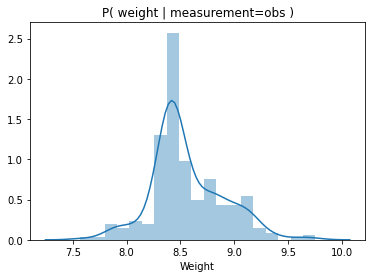

In [43]:
print("expected weight =", mcmc_samples['weight'].mean().item())

sns.distplot(mcmc_samples['weight'])
plt.title("P( weight | measurement=obs )")
plt.xlabel("Weight")
plt.show()

### Eight schools example using NUTS

Let's consider a hierarchical model of the Eight Schools dataset (Rubin, 1981), taken from chap. 5.5 of Gelman et al. "Bayesian Data Analysis" (2014). 
This study measures the effect of coaching programs on college admission tests and should reflect the knowledge that was acquired by the students from eight different schools.

For each school ($j=1,\ldots,8$) the dataset contains:
- the estimated effect of coaching $y_j$
- the standard error of the effect $\sigma_j$

In [23]:
J = 8
# estimated treatment effect
y = torch.tensor([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
# std of the estimated effect
sigma = torch.tensor([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

Some coaching programs have moderate effects (in the range 18–28 points), most have small
effects (0–12 points), and two have small negative effects.

We are interested in estimating the true effects of coaching $\tau_j$, by using the Bayesian model

\begin{align*}
\mu &\sim \mathcal{N}(0,5)\\
\tau &\sim \text{Half-Cauchy}(0,5)\\
\theta_j &\sim \mathcal{N}(\mu,\tau) \;\; j=1,\ldots,8\\
\tau_j &\sim \mathcal{N}(\theta_j,\sigma_j) \;\;j=1,\ldots,8
\end{align*}


In [38]:
def eight_schools(J, sigma, y=None):
    mu = pyro.sample('mu', dist.Normal(0, 5))
    tau = pyro.sample('tau', dist.HalfCauchy(5))
    with pyro.plate('J', J):
        theta = pyro.sample('theta', dist.Normal(mu, tau))
        pyro.sample('obs', dist.Normal(theta, sigma), obs=y)

HMC solves a two-state differential equation (over the parameters $\theta$ and the momentum $\rho$) using the *Leapfrog integrator* numerical integration algorithm. At each iteration, it takes $L$ discrete steps of some small time interval $\epsilon$.

We are now using **No U-Turn Sampler** (NUTS), a variant of HMC where $L$ and $\epsilon$ are adaptively determined at each iteration, based on the curvature of the log-density: the step size $\epsilon$ gets smaller in areas where the curvature is high, while the number of steps $L$ is large enough for the trajectory to move far through the posterior distribution without turning around.

In [40]:
kernel = NUTS(eight_schools)
mcmc = MCMC(kernel, warmup_steps=500, num_samples=100, num_chains=4)
mcmc.run(J=J, sigma=sigma, y=y)
mcmc.summary()






                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      6.58      3.59      6.87      0.90     12.22      9.45      1.22
       tau      3.46      3.01      2.37      0.73      7.71      7.89      1.24
  theta[0]      8.09      5.44      8.16     -0.11     16.74    138.48      1.02
  theta[1]      7.05      4.15      7.69      0.28     12.68     33.25      1.10
  theta[2]      5.94      5.62      6.87     -3.15     13.46     18.14      1.13
  theta[3]      6.70      4.93      7.20     -1.38     14.27     35.26      1.10
  theta[4]      5.80      5.00      6.52     -2.54     12.77      9.68      1.21
  theta[5]      6.46      4.69      6.97     -1.17     13.14     15.99      1.12
  theta[6]      8.36      4.41      8.55      1.80     15.55     66.79      1.04
  theta[7]      7.11      5.36      7.95      0.61     15.06     51.30      1.08

Number of divergences: 7


`mcmc.summary()` prints a summary table displaying the diagnostics of posterior samples. In particular, it includes:
- $5\%$ and $95\%$ credibility intervals for the estimates;
- the number of effective samples `n_eff`, representing the number of independent draws from the posterior distribution;
- the split-$\hat{R}$ statistic `r_hat`, which monitors whether the chains have converged to the equilibrium distribution or not. 

Values above 1 for `r_hat` and low values for `n_eff` indicate that some chains have not fully converged. 

Moreover, we can notice some **divergent transitions**, arising when the simulated Hamiltonian trajectory departs from the true trajectory, potentially reducing the algorithm to a simple random walk. Consequently, if the number of divergent transitions is high, the estimates cannot be trusted.

A **non-centered parametrization** for $\tau$ is able to solve all of these pathologies. Let's run NUTS on the equivalent model

\begin{align*}
\mu &\sim \mathcal{N}(0,5)\\
\tau &\sim \text{Half-Cauchy}(0,5)\\
\nu_j &\sim  \mathcal{N}(0,1) \;\; j=1,\ldots,8\\
\theta_j &= \mu + \tau\, \nu_j  \;\; j=1,\ldots,8\\
\tau_j &\sim \mathcal{N} (\theta_j,\sigma_j) \;\;j=1,\ldots,8
\end{align*}

In [35]:
def eight_schools_noncentered(J, sigma, y=None):
    mu = pyro.sample('mu', dist.Normal(0, 5))
    tau = pyro.sample('tau', dist.HalfCauchy(5))
    with pyro.plate('J', J):
        nu = pyro.sample('nu', dist.Normal(0., 1.))
        theta = mu + tau * nu
        pyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [27]:
nuts_kernel = NUTS(eight_schools_noncentered)
mcmc = MCMC(nuts_kernel, warmup_steps=500, num_samples=100, num_chains=4)
mcmc.run(J=J, sigma=sigma, y=y)
mcmc.summary()






                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      4.55      3.14      4.42     -0.63      9.37    350.82      0.99
       tau      3.29      2.82      2.67      0.01      7.27    303.70      1.01
     nu[0]      0.37      0.93      0.39     -1.09      1.87    723.01      1.00
     nu[1]      0.05      0.90      0.05     -1.26      1.58    409.06      1.00
     nu[2]     -0.13      1.10     -0.08     -1.99      1.56    332.40      1.00
     nu[3]      0.02      0.97      0.02     -1.64      1.46    498.03      0.99
     nu[4]     -0.18      0.93     -0.21     -1.54      1.49    499.72      1.00
     nu[5]     -0.13      0.91     -0.15     -1.75      1.26    552.61      0.99
     nu[6]      0.35      0.92      0.41     -1.11      1.83    370.72      1.00
     nu[7]      0.06      0.91      0.03     -1.38      1.54    649.58      0.99

Number of divergences: 0


## References

- M. Bentacourt, "A Conceptual Introduction to Hamiltonian Monte Carlo", 2018
- [tutorial on deep probabilistic modeling](https://bookdown.org/robertness/causalml/docs/tutorial-on-deep-probabilitic-modeling-with-pyro.html)
- Rubin D. B., "Estimation in parallel randomized experiments", 1981
- Gelman et al., "Bayesian Data Analysis", 2014
